In [ ]:
# Setup
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import os, json

from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Computer Vision/FungiDataset'
!ls

In [ ]:
# Preprocess and build dataset
labelsToInt = {"e": 0, "p": 1}

def build_dataset(datasetType):
    with open(f'train_val_annotations/labels-{datasetType}.json') as srcF:
        # Load the JSON data into a Python list
        fileLabels = json.load(srcF)
    paths = []
    labels = []
    for label in fileLabels:
        # filename = label['file_name']
        # filename = filename.split('/')
        # path = 'dataset/'+datasetType+'/' + '/'.join(filename[1:]) # skip 'image/'
        paths.append(label['file_name'])
        labels.append(labelsToInt[label['label']])
    # paths = tf.constant(paths)
    # labels = tf.constant(labels)

    def parse_image(filename, label):
        image_string = tf.io.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.cast(image_decoded, tf.float32)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(parse_image).shuffle(buffer_size=1000)
    return dataset

train_dataset = build_dataset('train')
val_dataset = build_dataset('val')

# Split train into train and test dataset
# train_size = int(0.9 * len(dataset))
# train_dataset = dataset.take(train_size)
# test_dataset = dataset.skip(train_size)

train_dataset, val_dataset

In [ ]:
# Preprocess dataset for RestNet50
def preprocess_dataset(dataset):
    def preprocess_data(image, label):
        image = tf.image.resize(image, [224, 224])
        image = tf.keras.applications.resnet50.preprocess_input(image)
        return image, label
    dataset = dataset.map(preprocess_data)
    dataset = dataset.batch(batch_size=32, drop_remainder= False)
    return dataset

rn50_train_dataset = preprocess_dataset(train_dataset)
rn50_val_dataset = preprocess_dataset(val_dataset)
# rn50_test_dataset = preprocess_dataset(test_dataset)

rn50_train_dataset, rn50_val_dataset

In [ ]:
# Function to build ResNet50 base model + custom classificaiton layers
def create_model(weights='imagenet'):
    base_model = tf.keras.applications.ResNet50(weights=weights, include_top=False, input_shape=(224,224,3))

    # # Freeze layer except last block
    # for layer in base_model.layers[:165]:
    #   layer.trainable = False

    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(len(labelsToInt.keys()), activation='softmax'))
    return model

In [ ]:
# Create model and load weights
# Fetch latest weights, if any
weights_dir = 'cnn_weights/'
with os.scandir(weights_dir) as entries:
    entries = [e for e in entries if not e.is_dir()]
    sorted_entries = sorted(entries, key=os.path.getmtime, reverse=True)
    print(f'Saved weights (most recently modified to least): {[s.name for s in sorted_entries]}')
    latest = weights_dir + sorted_entries[0].name if len(sorted_entries) > 0 else None
if latest:
  model = create_model(None)
  model.load_weights(latest)
  print(f"Model weights loaded from latest saved weights at: {latest}")
else:
  model = create_model(None)
  print("Model weights initialized randomly")
model.summary()

Saved weights (most recently modified to least): []
Model weights initialized randomly


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,164,386 (92.18 MB)

 Trainable params: 24,106,850 (91.96 MB)

 Non-trainable params: 57,536 (224.75 KB)

Epoch 1/7
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5993 - loss: 0.7221
Epoch 1: saving model to cnn_weights/cp-01.weights.h5
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 558s 317ms/step - accuracy: 0.5993 - loss: 0.7221 - val_accuracy: 0.6159 - val_loss: 0.7008
Epoch 2/7
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6353 - loss: 0.6472
Epoch 2: saving model to cnn_weights/cp-02.weights.h5
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 469s 297ms/step - accuracy: 0.6353 - loss: 0.6472 - val_accuracy: 0.6159 - val_loss: 0.8659
Epoch 3/7
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6337 - loss: 0.6414
Epoch 3: saving model to cnn_weights/cp-03.weights.h5
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 469s 296ms/step - accuracy: 0.6337 - loss: 0.6414 - val_accuracy: 0.6159 - val_loss: 0.6900
Epoch 4/7
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6385 - loss: 0.6459
Epoch 4: saving model to cnn_weights/cp-04.weights.h5
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 468s 296ms/step - accuracy: 

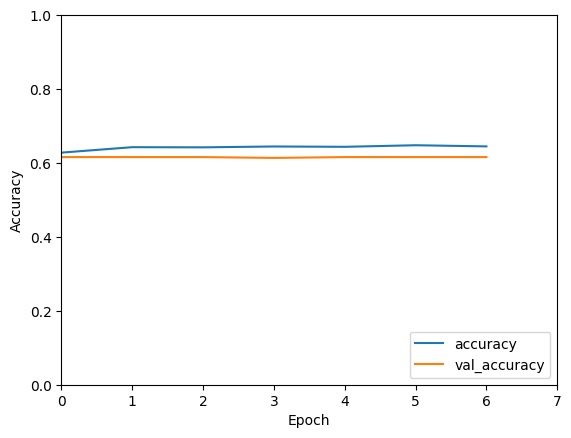

In [ ]:
# Train model
numEpochs = 7

model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics= ['accuracy'])

checkpoint_path = 'cnn_weights/cp-{epoch:02d}.weights.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
                  filepath=checkpoint_path,
                  verbose=1,
                  save_weights_only=True)

history = model.fit(rn50_train_dataset,
                    epochs= numEpochs,
                    validation_data= rn50_val_dataset,
                    callbacks= [cp_callback])

# Plot model accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xlim([0, numEpochs])
plt.legend(loc='lower right')

# Evaluate model on test dataset
# test_loss, test_acc = model.evaluate(rn50_test_dataset, verbose=2)
# print(f'Test dataset, accuracy: {test_acc} loss: {test_loss}')

In [ ]:
# Evaluate model on test dataset
model = create_model(None)
model.load_weights('cnn_weights/cp-06.weights.h5')

model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics= ['accuracy'])

test_loss, test_acc = model.evaluate(rn50_test_dataset, verbose=2)
print(f'Test dataset, accuracy: {test_acc} loss: {test_loss}')